In [1]:
%matplotlib inline

`21.7.28 ~ `21.8.1 Written by JungJaeHyung, reffered original Codes(Pytorch Cifar10 Classifying Tutorials)

Import Modules 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(299)])
# Resize images to fit in Size of IRnet(IR = Inception-Resnet)

batch_size = 8
# Set batch_size to minimum(8) because Architecture of IR is too heavy

# Download CIFAR10_train datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

# Download CIFAR10_test datasets
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Cifar10의 image 10개 load, print

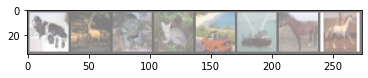

  dog  deer  frog   cat   car  ship horse horse


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Convolution Class 정의

In [5]:
class Convolution2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

Stem Class 정의

In [8]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            Convolution2d(3, 32, 3, stride=2, padding=0), #Input (299,299,3) ---Conv2D---> (149,149,32)
            Convolution2d(32, 32, 3, stride=1, padding=0),
            Convolution2d(32, 64, 3, stride=1, padding=1), # 147 x 147 x 64 
        )

        self.branch3x3_conv = Convolution2d(64, 96, 3, stride=2, padding=0) # 73x73x96

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branch3x3_pool = nn.MaxPool2d(4, stride=2, padding=1) # 73x73x64

        self.branch7x7a = nn.Sequential(
            Convolution2d(160, 64, 1, stride=1, padding=0),
            Convolution2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branch7x7b = nn.Sequential(
            Convolution2d(160, 64, 1, stride=1, padding=0),
            Convolution2d(64, 64, (7,1), stride=1, padding=(3,0)),
            Convolution2d(64, 64, (1,7), stride=1, padding=(0,3)),
            Convolution2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branchpoola = Convolution2d(192, 192, 3, stride=2, padding=0) # 35x35x192

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branchpoolb = nn.MaxPool2d(4, 2, 1) # 35x35x192
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1)
        x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)), dim=1)
        x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
        return x    
    
    # concatenate

Stem shape 확인

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Stem().to(device)

summary(model, (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
     Convolution2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
     Convolution2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
    Convolution2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

Inception-A class 정의

In [19]:
class Inception_A(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = Convolution2d(in_channels, 32, 1, stride=1, padding=0)

        self.branch3x3 = nn.Sequential(
            Convolution2d(in_channels, 32, 1, stride=1, padding=0),
            Convolution2d(32, 32, 3, stride=1, padding=1)
        )

        self.branch3x3stack = nn.Sequential(
            Convolution2d(in_channels, 32, 1, stride=1, padding=0),
            Convolution2d(32, 48, 3, stride=1, padding=1),
            Convolution2d(48, 64, 3, stride=1, padding=1)
        )
        
        self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(384)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1) # concatenate : 채널끼리 다더해줌
        x = self.reduction1x1(x)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

Inception A Shape 확인

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IR_Module_A(192).to(device)

summary(model, (192,35,35))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 35, 35]          74,112
            Conv2d-2           [-1, 32, 35, 35]           6,144
       BatchNorm2d-3           [-1, 32, 35, 35]              64
              ReLU-4           [-1, 32, 35, 35]               0
     Convolution2d-5           [-1, 32, 35, 35]               0
            Conv2d-6           [-1, 32, 35, 35]           6,144
       BatchNorm2d-7           [-1, 32, 35, 35]              64
              ReLU-8           [-1, 32, 35, 35]               0
     Convolution2d-9           [-1, 32, 35, 35]               0
           Conv2d-10           [-1, 32, 35, 35]           9,216
      BatchNorm2d-11           [-1, 32, 35, 35]              64
             ReLU-12           [-1, 32, 35, 35]               0
    Convolution2d-13           [-1, 32, 35, 35]               0
           Conv2d-14           [-1, 32,

Reduction-A 정의

In [20]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3 = Convolution2d(in_channels, n, 3, stride=2, padding=0)
        self.branch3x3stack = nn.Sequential(
            Convolution2d(in_channels, k, 1, stride=1, padding=0),
            Convolution2d(k, l, 3, stride=1, padding=1),
            Convolution2d(l, m, 3, stride=2, padding=0)
            )

        self.output_channels = in_channels + n + m

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        return x

Reduction A shape 확인

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReductionA(384, 256, 256, 384, 384).to(device)

summary(model, (384, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1        [-1, 384, 127, 127]               0
            Conv2d-2        [-1, 384, 127, 127]       1,327,104
       BatchNorm2d-3        [-1, 384, 127, 127]             768
              ReLU-4        [-1, 384, 127, 127]               0
     Convolution2d-5        [-1, 384, 127, 127]               0
            Conv2d-6        [-1, 256, 256, 256]          98,304
       BatchNorm2d-7        [-1, 256, 256, 256]             512
              ReLU-8        [-1, 256, 256, 256]               0
     Convolution2d-9        [-1, 256, 256, 256]               0
           Conv2d-10        [-1, 256, 256, 256]         589,824
      BatchNorm2d-11        [-1, 256, 256, 256]             512
             ReLU-12        [-1, 256, 256, 256]               0
    Convolution2d-13        [-1, 256, 256, 256]               0
           Conv2d-14        [-1, 384, 1

Inception B Class 정의

In [ ]:
class Inception_B(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = Convolution2d(in_channels, 32, 1, stride=1, padding=0)

        self.branch3x3 = nn.Sequential(
            Convolution2d(in_channels, 32, 1, stride=1, padding=0),
            Convolution2d(32, 32, 3, stride=1, padding=1)
        )

        self.branch3x3stack = nn.Sequential(
            Convolution2d(in_channels, 32, 1, stride=1, padding=0),
            Convolution2d(32, 48, 3, stride=1, padding=1),
            Convolution2d(48, 64, 3, stride=1, padding=1)
        )
        
        self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(384)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        x = self.reduction1x1(x)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x